# 第十一週：Text Presentation
本周課程為「Text Presentation」，主要會使用到gensim套件來實現自行訓練word2vec模型以及使用預訓練word2vec模型，以及透過sentence-transformers以及API取得embeddings。


### 大綱：
1.   DEMO
*   Word2Vec
  *   自己訓練w2v模型
  *   使用別人訓練好的w2v模型
*   Transformers Embeddings
  *   小模型（BERT）：
      *   不同語言的BERT：uncased / chinese / multilingual
  *   大模型（LLM）：
      *   API based
      *   Open Source LLM  

2.   資料集實作任務
*    使用embedding 做 NLP 任務
  *   找相似文件（文章）
  *   文件分類任務


### 套件安裝

連接雲端資料夾

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('你的雲端資料夾路徑') #切換該目錄
os.listdir() #確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['TaipeiSansTCBeta-Regular.ttf',
 'dict',
 'tmunlp_1.6B_WB_50dim_2020v1.bin',
 'raw_data',
 'classification_with_embeddings.ipynb',
 'NLP_DL.ipynb']

In [3]:
# !pip install scikit-learn-extra
# !pip install jieba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 48.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314459 sha256=7d61f0f97927ba72a7e9ee185c2738dd961fc7c2397b6ef21c85f36e16efa6b6
  Stored in directory: /root/.cache/pip/wheels/c9/69/31/d56d90b22a1777b0b231e234b00302a55be255930f8bd92dcd
Successfully built jieba


In [4]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch
sns.set_style("darkgrid")


### 資料前處理

讀入吃到飽示範資料集

In [5]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [6]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [7]:
# 讀入中文示範資料集
origin_data = pd.read_csv('./raw_data/zh_buffet_20_22.csv')

In [ ]:
# 資料前處理

# 去除一些不需要的欄位
metaData = origin_data.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData

Building prefix dict from /content/drive/MyDrive/NSYSU/31lab/112_2_SMA/week11/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/NSYSU/31lab/112_2_SMA/week11/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.u064d25a4a470e3be4b9d580c413a3e8a.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.u064d25a4a470e3be4b9d580c413a3e8a.cache
Loading model cost 1.525 seconds.
DEBUG:jieba:Loading model cost 1.525 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月,"[餐廳, 名稱, 咖哩, 消費, 時間, 例年]"
1,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,未提供則文章不予保留,"[提供, 文章, 不予, 保留]"
2,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,多訪綜合心得也請標上起迄時間地址台北市開封街段巷號電話營業時間每人平均價位可否刷卡有無包廂推...,"[多訪, 綜合, 心得, 標上, 時間, 地址, 台北市, 開封, 街段, 巷號, 電話, ..."
3,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,加飯加咖哩醬都免錢一直加飯加醬的話真的可以元吃到飽照片的是雞肉咖哩青菜雞肉用的是雞腿肉大概有...,"[加飯, 咖哩, 免錢, 加飯, 加醬, 真的, 照片, 雞肉, 咖哩, 青菜, 雞肉, 雞..."
4,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,其他的口味也吃過肉塊都不少豬肉用的是後腿肉牛肉用的是牛腱肉不會像大部分的平價咖哩飯醬吃起來都...,"[口味, 過肉塊, 豬肉, 後腿, 牛肉, 牛腱, 大部分, 平價, 咖哩, 飯醬, 味道,..."
...,...,...,...,...,...,...,...
142627,1630,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,總體來說,[總體]
142628,1630,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,這家頂鮮台南擔仔麵雖然對我們來說價格不算便宜,"[頂鮮, 台南, 擔仔, 價格, 便宜]"
142629,1630,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,但菜色跟口味確實都有一定的水準,"[菜色, 口味, 確實, 水準]"
142630,1630,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,蠻適合在家族年節團聚或招待長輩時前來用餐,"[適合, 家族, 年節, 團聚, 招待, 長輩, 前來, 用餐]"


### word2vec


####（1）如何自己訓練word2vec模型

建立訓練資料時將考慮bigram，以下為Phrases函式的使用示範

In [ ]:
docs = ['new york is united states', 'new york is most populated city in the world','i love to stay in new york']

token_ = [doc.split(" ") for doc in docs]
# Phrases 建立bigram,
# 少於min_count的字的字或bigrams會被忽略,
# 大於threshold的bigrams會被加入
bigram = Phrases(token_, min_count=1, threshold=2)
bigram_phraser = Phraser(bigram)

for sent in token_:
    print(sent)  #處理前
    print("=> ",bigram_phraser[sent]) # 處理後，還是原本的句子，只是有抓出的bigram片語會被合併

['new', 'york', 'is', 'united', 'states']
=>  ['new_york', 'is', 'united', 'states']
['new', 'york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
=>  ['new_york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
['i', 'love', 'to', 'stay', 'in', 'new', 'york']
=>  ['i', 'love', 'to', 'stay', 'in', 'new_york']


實際應用在資料集上

In [ ]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word,word_list_bigrams
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月,"[餐廳, 名稱, 咖哩, 消費, 時間, 例年]","[餐廳, 名稱, 咖哩, 消費, 時間, 例年]"
1,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,未提供則文章不予保留,"[提供, 文章, 不予, 保留]","[提供, 文章_不予, 保留]"
2,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,多訪綜合心得也請標上起迄時間地址台北市開封街段巷號電話營業時間每人平均價位可否刷卡有無包廂推...,"[多訪, 綜合, 心得, 標上, 時間, 地址, 台北市, 開封, 街段, 巷號, 電話, ...","[多訪, 綜合, 心得_標上, 時間, 地址, 台北市, 開封, 街段, 巷號, 電話, 營..."
3,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,加飯加咖哩醬都免錢一直加飯加醬的話真的可以元吃到飽照片的是雞肉咖哩青菜雞肉用的是雞腿肉大概有...,"[加飯, 咖哩, 免錢, 加飯, 加醬, 真的, 照片, 雞肉, 咖哩, 青菜, 雞肉, 雞...","[加飯, 咖哩, 免錢, 加飯, 加醬, 真的, 照片, 雞肉, 咖哩, 青菜, 雞肉, 雞..."
4,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,其他的口味也吃過肉塊都不少豬肉用的是後腿肉牛肉用的是牛腱肉不會像大部分的平價咖哩飯醬吃起來都...,"[口味, 過肉塊, 豬肉, 後腿, 牛肉, 牛腱, 大部分, 平價, 咖哩, 飯醬, 味道,...","[口味, 過肉塊, 豬肉, 後腿, 牛肉, 牛腱, 大部分, 平價, 咖哩, 飯醬, 味道,..."


In [ ]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [ ]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 47343


['餐廳', '不錯', '用餐', '好吃', '時間', '真的', '喜歡', '口感', '提供', '火鍋']

In [ ]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 136350
average length of sentences: 3.7127099376604327


Word2Vec 計算

In [ ]:
# 環境變數設定
%env PYTHONHASHSEED=8787

env: PYTHONHASHSEED=8787


In [ ]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 2


In [ ]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     #  negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

查看結果

In [ ]:
# 檢查最相關的字
w2v_model.wv.most_similar('餐廳',topn=10)

[('自助餐', 0.7362877130508423),
 ('飯店', 0.7085329294204712),
 ('牛排館', 0.6864142417907715),
 ('市場', 0.6767591238021851),
 ('酒店', 0.6676768660545349),
 ('饗食_天堂', 0.6675432920455933),
 ('鍋物', 0.6567007303237915),
 ('餐館', 0.6491333842277527),
 ('連鎖店', 0.6415016055107117),
 ('日本料理', 0.6368252038955688)]

In [ ]:
w2v_model.wv.most_similar('火鍋',topn=10)

[('火鍋店', 0.621479868888855),
 ('鍋物', 0.5924753546714783),
 ('蔬菜', 0.5899842381477356),
 ('小火鍋', 0.5736534595489502),
 ('熱炒', 0.5340964794158936),
 ('燒烤', 0.5328350067138672),
 ('麻辣鍋', 0.5154083967208862),
 ('主打', 0.5052646398544312),
 ('素食', 0.49024948477745056),
 ('自助', 0.488309383392334)]

In [ ]:
w2v_model.wv.most_similar(['火鍋','餐廳'],topn=10)

[('鍋物', 0.7806140184402466),
 ('火鍋店', 0.7760403156280518),
 ('小火鍋', 0.6899278163909912),
 ('牛排館', 0.6574103832244873),
 ('自助餐', 0.6557640433311462),
 ('火烤_兩吃', 0.6416258811950684),
 ('湯鍋', 0.6352009177207947),
 ('乃葉', 0.6259719729423523),
 ('鐵板燒', 0.6176043152809143),
 ('新馬辣', 0.6122105717658997)]

In [ ]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['火鍋','餐廳'],topn=10)

[('煙燻', 0.37475815415382385),
 ('鮮美', 0.3683283030986786),
 ('很夠', 0.361502081155777),
 ('椒鹽', 0.3552986681461334),
 ('鴨肉', 0.35005444288253784),
 ('微焦', 0.328083336353302),
 ('飽滿', 0.3276236653327942),
 ('扇貝', 0.32590702176094055),
 ('切片', 0.3258465528488159),
 ('濃郁', 0.3237309157848358)]

In [ ]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("台北","台南")

0.7383523

In [ ]:
w2v_model.wv.similarity("口感","香氣")

0.67619014

In [ ]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["口感", "香氣", '台北'])

'台北'

In [ ]:
# 相對關係
w2v_model.wv.most_similar(positive=["台北"], negative=["台南"], topn=5)

[('鄰近', 0.5270470976829529),
 ('站號_出口', 0.5001472234725952),
 ('號近', 0.4900150001049042),
 ('中山站', 0.47887900471687317),
 ('出口', 0.45342588424682617)]

In [ ]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

視覺化字之間的關係及將字做分群

In [ ]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat


In [ ]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)


In [ ]:
getVecs(w2v_model,['餐廳','美食'])

array([[-0.00463246,  0.139197  ,  0.20719205,  0.28343272,  0.25121853,
        -0.35211855,  0.33796144,  0.18316142,  0.16893885,  0.2787276 ,
        -0.03091388,  0.11850645, -0.46732658, -0.02562205, -0.22336213,
         0.14276084,  0.112977  , -0.2589601 ,  0.2774425 ,  0.42921743,
         0.05361275,  0.18986966,  0.0815509 ,  0.1146043 , -0.00380132,
         0.6813003 ,  0.3449577 ,  0.2969511 , -0.16562104,  0.18152772,
         0.21989897,  0.04837458,  0.01970267,  0.2587276 ,  0.5085063 ,
         0.21468373, -0.06548299, -0.38043597, -0.22640376, -0.05627358,
         0.23281853, -0.14028567, -0.20663817,  0.09333961, -0.18526077,
         0.18783851, -0.27199414,  0.6411997 ,  0.23432389, -0.17877333,
         0.06908907,  0.16734757, -0.23489863, -0.18747954, -0.1874499 ,
        -0.36635038, -0.3919902 , -0.12568353,  0.02366173,  0.06929248,
        -0.38055307, -0.14017221, -0.02532971,  0.07286316,  0.08986931,
        -0.31364372,  0.27735418,  0.1014474 ,  0.1

In [ ]:
# 擴展相似的字詞
def expandPosWord(model,words:list,top_n:int,split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])
    return list(set(expand))


In [ ]:
expandPosWord(w2v_model,['餐廳','熱炒'],top_n = 10)

['傳統',
 '自助餐',
 '酒店',
 '市場',
 '連鎖店',
 '鍋物',
 '台式',
 '元素',
 '餐館',
 '牛排館',
 '素食',
 '日本料理',
 '特色',
 '饗食_天堂',
 '中式',
 '飯店',
 '主題',
 '創意',
 '燒烤',
 '蔬食']

In [ ]:
from matplotlib.font_manager import fontManager
import plotly.express as px
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()
# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [ ]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [ ]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

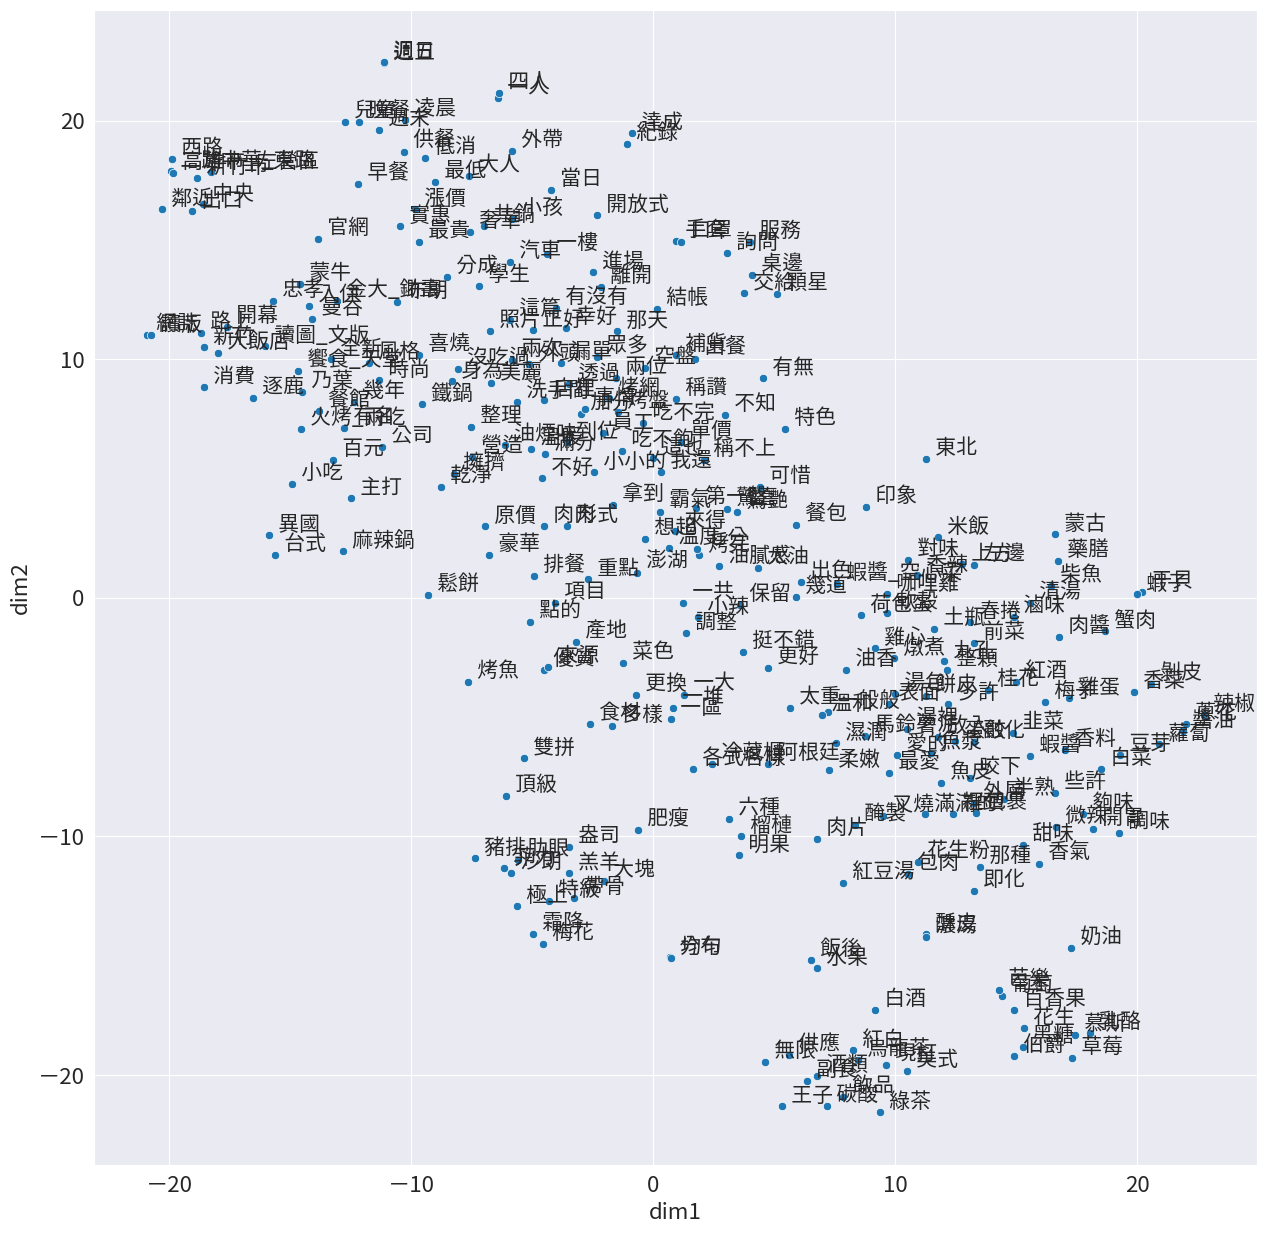

In [ ]:
plotScatter(word_df)

3D 散狀圖

In [ ]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(300, 3)


將字分群

In [80]:
!pip install scikit-learn-extra

In [81]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result


In [82]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



####（2）如何使用別人訓練好的word2vec模型

臺北醫學大學做的預訓練 Word2Vec 模型，來源：http://nlp.tmu.edu.tw/word2vec/index.html

In [83]:
model_tmu = KeyedVectors.load_word2vec_format('./tmunlp_1.6B_WB_50dim_2020v1.bin', unicode_errors='ignore', binary=True)

In [84]:
model_tmu.most_similar('癌症',topn=10)

[('肝癌', 0.8965061902999878),
 ('乳癌', 0.894655168056488),
 ('肺癌', 0.8924040198326111),
 ('肝病', 0.8478196859359741),
 ('大腸癌', 0.8448510766029358),
 ('糖尿病', 0.8433824181556702),
 ('口腔癌', 0.8214656710624695),
 ('疾病', 0.8192287683486938),
 ('胃癌', 0.8169611096382141),
 ('腸癌', 0.8160045742988586)]

In [85]:
model_tmu.most_similar('咳嗽',topn=10)

[('流鼻水', 0.8725693225860596),
 ('鼻塞', 0.8663491010665894),
 ('嘔吐', 0.8655411601066589),
 ('腹瀉', 0.8551325798034668),
 ('感冒', 0.8539074063301086),
 ('乾咳', 0.8232213854789734),
 ('胸悶', 0.8225348591804504),
 ('胸痛', 0.8140345811843872),
 ('腹痛', 0.8083592057228088),
 ('頭暈', 0.8059035539627075)]

In [86]:
model_tmu.most_similar(positive=['疾病','咳嗽'],topn=10)

[('症狀', 0.8799884915351868),
 ('癥狀', 0.8648518919944763),
 ('哮喘', 0.8594630360603333),
 ('慢性', 0.8578190803527832),
 ('氣喘', 0.8548911809921265),
 ('感冒', 0.8509713411331177),
 ('腹瀉', 0.8316847085952759),
 ('病症', 0.8148555159568787),
 ('急性', 0.8118695020675659),
 ('癲癇', 0.802987277507782)]

### Transformers Embeddings

#### 使用 Sentence-Transformer 套件   
參考資料：https://www.sbert.net/index.html

In [8]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.7 MB/s eta 0:00:00


In [9]:
from sentence_transformers import SentenceTransformer, models, util

#### 小模型，以BERT為範例

註：在挑選語言模型時需確認其訓練資料的來源，因為不一定都具備跨語言的能力。   
接下來將以針對英文、中文以及多語言進行訓練的三種BERT模型做範例。

In [42]:
# 英文 bert-base-uncased
bert_en = SentenceTransformer('google-bert/bert-base-uncased')

bert_en.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

In [44]:
bert_en.get_max_seq_length()

512

In [45]:
example_text = "This framework generates embeddings for each input sentence"
example_embeddings = bert_en.encode(example_text)

print(example_embeddings.shape)
print("=======================")
print(example_embeddings)

(768,)
[-1.25634462e-01 -2.35391092e-02  9.72141027e-02 -2.14602157e-01
 -4.24758270e-02 -7.68921711e-03  1.66508421e-01  2.09751859e-01
  1.94057614e-01 -9.31545645e-02 -1.04050986e-01 -1.99633911e-01
 -3.48384023e-01  8.10465962e-02 -1.62070300e-02  1.90525740e-01
  5.29038080e-04  1.45439178e-01 -5.54174185e-04 -1.58491224e-01
  1.94275126e-01  1.59165546e-01 -5.99901617e-01  2.65522182e-01
  7.47946143e-01 -2.46598176e-03  1.04436830e-01  1.66958258e-01
 -3.53779316e-01  1.39418587e-01  3.89939174e-02  6.57110155e-01
 -6.23243954e-03 -2.85024077e-01 -1.56140909e-01  8.45852420e-02
  1.65655389e-01 -2.55370468e-01 -1.16442680e-01  9.59284604e-02
 -6.72327161e-01 -3.47994626e-01  8.42593163e-02 -2.06027582e-01
 -5.32231145e-02 -4.90706772e-01 -9.41146351e-03 -3.81041318e-01
  5.67956120e-02 -6.35588408e-01 -1.04700696e+00  3.73333335e-01
  1.31077379e-01  3.08176935e-01 -2.27984279e-01  8.04124415e-01
  1.21666342e-01 -7.21640289e-01  3.69302124e-01 -1.17349744e-01
  1.25593245e-01 -

In [29]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence",
    "The quick brown fox jumps over the lazy dog.",
    "The speedy black dog leaps across the cat."
]

# 使用 encode() 對資料做embedding
embeddings_en = bert_en.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_en, embeddings_en)

# 印出句子間的cosine similarity分數
result = []
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
result_df.sort_values("score", ascending = False)

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,The speedy black dog leaps across the cat.,0.880907
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.499376
1,This framework generates embeddings for each i...,The speedy black dog leaps across the cat.,0.480858


因為後續在查看結果時會一直使用到此程式碼，所以包成function以便之後使用。

In [30]:
# 回傳cosine similarity分數
def get_result_df(sentences, cosine_scores):

  result = []
  for i in range(len(sentences)):
      for j in range(i+1, len(sentences)):
          result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

  result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
  result_df = result_df.sort_values("score", ascending = False)

  return result_df

中文 bert-base-chinese

In [31]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

In [32]:
# 示範句子
sentences = [
    "今天天氣很好。",
    "今天是個晴空萬里的好天氣。",
    "我晚上想去公園散步。"
]

# 使用 encode() 對資料做embedding
embeddings_ch = bert_ch.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_ch, embeddings_ch)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
0,今天天氣很好。,今天是個晴空萬里的好天氣。,0.914067
1,今天天氣很好。,我晚上想去公園散步。,0.787589
2,今天是個晴空萬里的好天氣。,我晚上想去公園散步。,0.759642


多語言 bert-base-multilingual-cased

In [33]:
# 多語言 bert-base-multilingual-cased
bert_multi = SentenceTransformer('google-bert/bert-base-multilingual-cased')

bert_multi.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

0

In [35]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "敏捷的棕色狐狸跳過了懶惰的狗。"
]

# 使用 encode() 對資料做embedding
embeddings_multi = bert_multi.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_multi, embeddings_multi)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,敏捷的棕色狐狸跳過了懶惰的狗。,0.588525
1,This framework generates embeddings for each i...,敏捷的棕色狐狸跳過了懶惰的狗。,0.362765
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.350700


#### 大模型範例

In [10]:
!pip install tiktoken
!pip install utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=31d3ffd33b08dda4af2f830144364ea6c51d58dabbc6ed05535592c0d1232019
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


#### (1)API based

##### OpenAI

**注意**   
Openai的API會要求綁定信用卡後才能使用，且綁定信用卡後會刷5美金的初始費用。   
請自行斟酌是否要嘗試這一部分的程式碼！


In [ ]:
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00


In [13]:
# from openai import OpenAI
import openai
import os

openai.api_key = '你的API_KEY' # 設置API_KEY

def get_embedding_openai(text, model):
   #text = text.replace("\n", " ")
   return openai.embeddings.create(input = [text], model=model).data[0].embedding

In [14]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [17]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "敏捷的棕色狐狸跳過了懶惰的狗。",
    "速い茶色のキツネが怠惰な犬を飛び越える"
]

# 取得每一句的embedding
embeddings_openai = [get_embedding_openai(text, model=embedding_model) for text in sentences]

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_openai, embeddings_openai)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
3,The quick brown fox jumps over the lazy dog.,敏捷的棕色狐狸跳過了懶惰的狗。,0.598573
5,敏捷的棕色狐狸跳過了懶惰的狗。,速い茶色のキツネが怠惰な犬を飛び越える,0.572717
4,The quick brown fox jumps over the lazy dog.,速い茶色のキツネが怠惰な犬を飛び越える,0.493010
2,This framework generates embeddings for each i...,速い茶色のキツネが怠惰な犬を飛び越える,0.050702
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.030703
1,This framework generates embeddings for each i...,敏捷的棕色狐狸跳過了懶惰的狗。,0.024827


##### Cohere

In [18]:
!pip install cohere

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.1 MB/s eta 0:00:00


In [19]:
import cohere

co = cohere.Client("你的API_KEY") # 設置API_KEY

embedding_model = "embed-multilingual-v3.0"

def get_embedding_cohere(text, model):
   #text = text.replace("\n", " ")
   return co.embed(texts=[text], model=model, input_type="classification").embeddings[0]

In [20]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "敏捷的棕色狐狸跳過了懶惰的狗。",
    "速い茶色のキツネが怠惰な犬を飛び越える"
]

# 使用 encode() 對資料做embedding
embeddings_cohere = [get_embedding_cohere(text, model=embedding_model) for text in sentences]

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_cohere, embeddings_cohere)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
5,敏捷的棕色狐狸跳過了懶惰的狗。,速い茶色のキツネが怠惰な犬を飛び越える,0.707117
3,The quick brown fox jumps over the lazy dog.,敏捷的棕色狐狸跳過了懶惰的狗。,0.706838
4,The quick brown fox jumps over the lazy dog.,速い茶色のキツネが怠惰な犬を飛び越える,0.631464
1,This framework generates embeddings for each i...,敏捷的棕色狐狸跳過了懶惰的狗。,0.279418
2,This framework generates embeddings for each i...,速い茶色のキツネが怠惰な犬を飛び越える,0.261698
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.227097


#### (2) Open Source LLM

##### LLaMA2

In [46]:
from huggingface_hub import notebook_login
notebook_login() # 輸入Hugging Face 帳號的Token

In [22]:
model_llama = SentenceTransformer('meta-llama/Llama-2-7b-hf')

model_llama.tokenizer.pad_token = model_llama.tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [38]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "The speedy white fox leaps across the dog."
]

# 使用 encode() 對資料做embedding
embeddings_llama = model_llama.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_llama, embeddings_llama)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,The speedy white fox leaps across the dog.,0.564812
1,This framework generates embeddings for each i...,The speedy white fox leaps across the dog.,0.515457
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.391589


##### Phi-2

In [25]:
model_phi2 = SentenceTransformer('microsoft/phi-2')

model_phi2.tokenizer.pad_token = model_phi2.tokenizer.eos_token
# embeddings = model_phi2.encode(['This is example of using phi2'])

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [26]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence",
    "The quick brown fox jumps over the lazy dog.",
    "The speedy black dog leaps across the cat."
]

# 使用 encode() 對資料做embedding
embeddings_phi2 = model_phi2.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_phi2, embeddings_phi2)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,The speedy black dog leaps across the cat.,0.828458
1,This framework generates embeddings for each i...,The speedy black dog leaps across the cat.,0.745847
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.691690


這裡需注意一下，上述的兩個LLM基本上是decoder-only，它們主要的任務目標是要生成下一個字，並不是主要拿來做sentence embedding的。   
有興趣的同學可以參考[embedding相關任務的leaderboard](https://huggingface.co/spaces/mteb/leaderboard)，試試上面的模型。

### 使用embedding做NLP任務

#### 相似文件

In [ ]:
df_similar = origin_data[['system_id','artTitle', 'artContent']]
df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_similar.head(5)

<ipython-input-12-ba0ea2bb5f29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))


,system_id,artTitle,artContent
0,1,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...
1,2,[抱怨]ATT4FUN乾杯點沙朗多注意,餐廳名稱乾杯地址乾杯電話消費時間年月號事發經過元旦跟女朋友晚上訂了位以前都會點上等牛排吃過很...
2,3,[食記]台北大安區六張犁站捷運小慧涼麵,餐廳名稱小慧涼麵消費時間年月起多訪地址台北市大安區臥龍街巷號電話營業時間週日公休每人平均價位...
3,4,[食記]福岡-運河城旁國產牛燒肉-WEST,消費時間年月在運河城逛累了當然要吃東西補充體力了喔最大的特色就是有包廂的設計不只提供中文菜單...
4,5,[食記]長榮皇璽桂冠艙飛機餐SEA-TPE聖誕好運,店名長榮皇璽桂冠艙飛機餐地址無電話無營業時間依機艙供餐時間為準個人平均消費依機票價格為主適合...


In [ ]:
corpus_embeddings = bert_ch.encode(df_similar['artContent'], convert_to_tensor=True)

query_num = 6 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: [食記]台中新開幕平價火鍋-聊聊鍋物(東海店)

 資料集中前五相似的文章:
[食記]台中新開幕平價火鍋-聊聊鍋物(東海店) (Score: 1.0000)
[食記]台北這一小鍋，台北車站人氣小火鍋 (Score: 0.9923)
[食記]高雄一炎九鼎-本體是薯條吃到飽平價火鍋 (Score: 0.9903)
[食記]新北辛海鍋物299免服務費平價吃到飽 (Score: 0.9898)
[食記]台中FOND訪韓國傳統豆腐鍋(老虎城店) (Score: 0.9897)






In [ ]:
query_num = 30

query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: [食記]台北哞哞屋和牛燒肉

 資料集中前五相似的文章:
[食記]台北哞哞屋和牛燒肉 (Score: 1.0000)
[食記]台北金舌燒肉KintanBuffet (Score: 0.9885)
[食記]西門町肉次方燒肉吃到飽 (Score: 0.9878)
[食記]桃園-單點式炭火燒肉-米炭火燒肉小酒館 (Score: 0.9870)
[食記]-羿燒肉-中壢少見的幫剝蝦殼服務 (Score: 0.9866)




